In [7]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/MRIs.zip'
to = '../MRI/MRIs.zip'
wget.download(url, to)

'../MRI/MRIs (1).zip'

In [9]:
import zipfile

with zipfile.ZipFile(to, 'r') as zip_ref:
    zip_ref.extractall('../MRI/')

In [10]:
import os 
from pathlib import Path

path = Path('../MRI/MRIs')
imgs = [path/'MRIs'/i for i in os.listdir(path/'MRIs')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
masks = [path/'Segmentations'/f'segm_{ix}' for ix in ixs]

len(imgs), len(masks)

(425, 425)

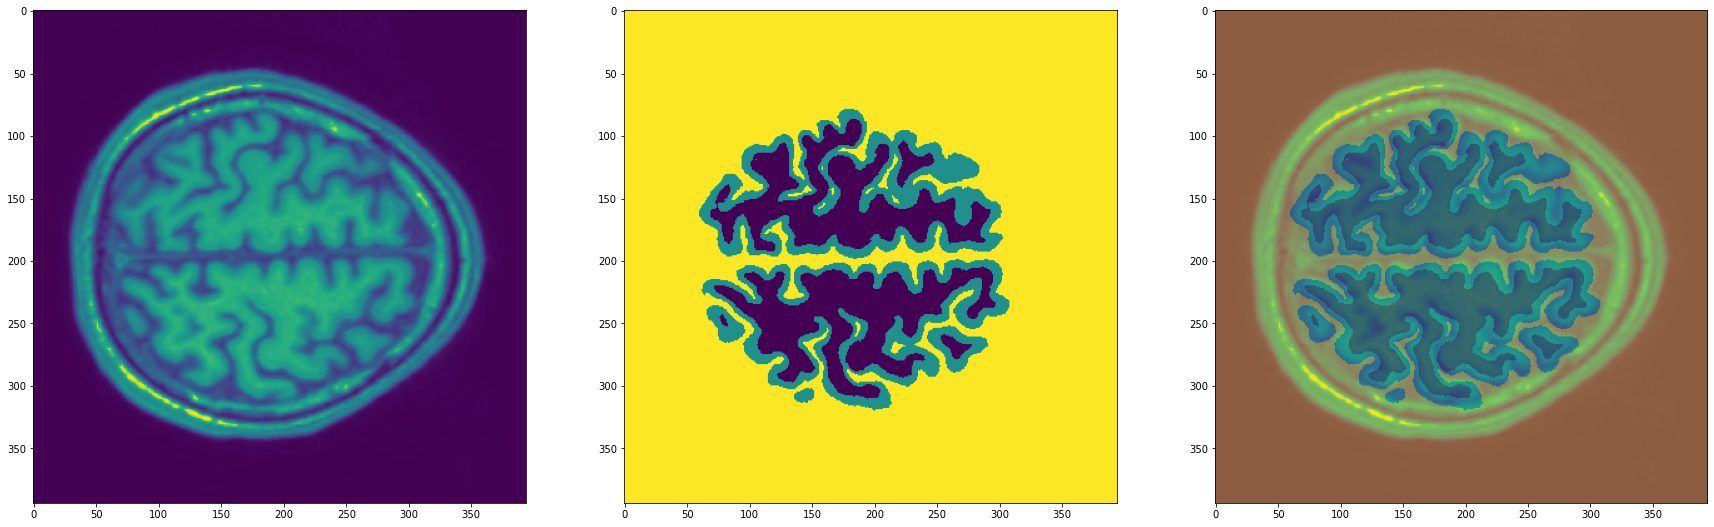

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

In [12]:
img.shape, img.dtype, img.max(), img.min()

((394, 394), dtype('float32'), 1.0269145, 0.00025629325)

In [13]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

In [14]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [15]:
import torch
import torch.nn.functional as F

number_of_classes = mask.max() + 1 # 3 classes
number_of_channels = 1  # grayscale

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [16]:
model = UNet()
output = model(torch.randn((10,1,394,394)))
output.shape

torch.Size([10, 3, 394, 394])

## Fit de 1 muestra

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [27]:
img_tensor = torch.tensor(img)
print(f'img_tensor.shape {img_tensor.shape}')
img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)   # (1, 1, H, W)
print(f'img_tensor.shape {img_tensor.shape}')

mask_tensor = torch.tensor(mask_oh)
print(f'mask_tensor.shape {mask_tensor.shape}')
mask_tensor = mask_tensor.permute(2, 0, 1).unsqueeze(0)
print(f'mask_tensor.shape {mask_tensor.shape}')

img_tensor.shape, mask_tensor.shape

img_tensor.shape torch.Size([394, 394])
img_tensor.shape torch.Size([1, 1, 394, 394])
mask_tensor.shape torch.Size([394, 394, 3])
mask_tensor.shape torch.Size([1, 3, 394, 394])


(torch.Size([1, 1, 394, 394]), torch.Size([1, 3, 394, 394]))

In [28]:
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.72044
Epoch 2/20 loss 0.68894
Epoch 3/20 loss 0.66641
Epoch 4/20 loss 0.64947
Epoch 5/20 loss 0.63499
Epoch 6/20 loss 0.62171
Epoch 7/20 loss 0.60984
Epoch 8/20 loss 0.59944
Epoch 9/20 loss 0.58994
Epoch 10/20 loss 0.58099
Epoch 11/20 loss 0.57245
Epoch 12/20 loss 0.56415
Epoch 13/20 loss 0.55596
Epoch 14/20 loss 0.54775
Epoch 15/20 loss 0.53944
Epoch 16/20 loss 0.53113
Epoch 17/20 loss 0.52292
Epoch 18/20 loss 0.51485
Epoch 19/20 loss 0.50694
Epoch 20/20 loss 0.49918


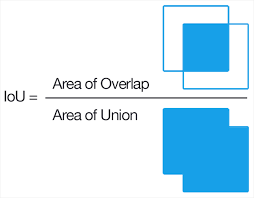

In [29]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [30]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [31]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.49158 iou 0.48424
Epoch 2/100 loss 0.46878 iou 0.51630
Epoch 3/100 loss 0.44573 iou 0.55432
Epoch 4/100 loss 0.42046 iou 0.57908
Epoch 5/100 loss 0.39864 iou 0.59649
Epoch 6/100 loss 0.37773 iou 0.62361
Epoch 7/100 loss 0.35775 iou 0.63936
Epoch 8/100 loss 0.33985 iou 0.64930
Epoch 9/100 loss 0.32326 iou 0.66115
Epoch 10/100 loss 0.30761 iou 0.67134
Epoch 11/100 loss 0.29296 iou 0.68183
Epoch 12/100 loss 0.27872 iou 0.69497
Epoch 13/100 loss 0.26572 iou 0.70252
Epoch 14/100 loss 0.25303 iou 0.71053
Epoch 15/100 loss 0.24159 iou 0.71849
Epoch 16/100 loss 0.23220 iou 0.72974
Epoch 17/100 loss 0.22641 iou 0.68434
Epoch 18/100 loss 0.21279 iou 0.73537
Epoch 19/100 loss 0.20564 iou 0.73561
Epoch 20/100 loss 0.19518 iou 0.74426
Epoch 21/100 loss 0.18716 iou 0.74672
Epoch 22/100 loss 0.17874 iou 0.76145
Epoch 23/100 loss 0.17140 iou 0.78024
Epoch 24/100 loss 0.16429 iou 0.78606
Epoch 25/100 loss 0.15750 iou 0.78610
Epoch 26/100 loss 0.15120 iou 0.79471
Epoch 27/100 loss 0.1

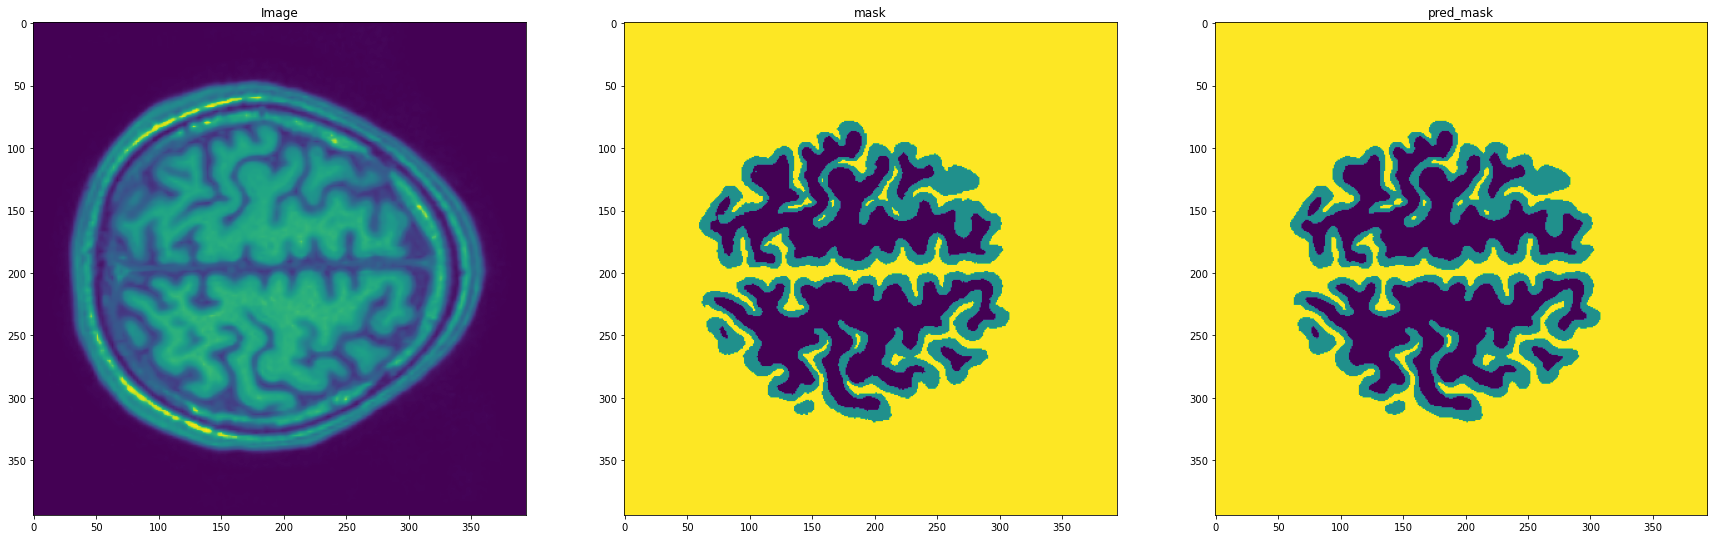

output.shape = torch.Size([3, 394, 394]), pred_mask.shape = torch.Size([394, 394])


In [37]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax1.set_title('Image')
ax2.imshow(mask)
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

In [38]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    img = torch.tensor(img).unsqueeze(0)    # (1, H, W) add channel dimension
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32)     # (H, W, n_classes) one-hot encoding
    mask = torch.from_numpy(mask).permute(2,0,1) # (n_classes, H, W)
    return img, mask

In [41]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

print(f"Había {len(imgs)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['test'])} imágenes de prueba")

Había 425 imágenes en el dataset, lo hemos dividido en 325 imágenes de entrenamiento y 100 imágenes de prueba


In [45]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs_train_sample, masks_train_sample = next(iter(dataloader['train']))
imgs_test_sample, masks_test_sample = next(iter(dataloader['test']))
imgs_train_sample.shape, masks_train_sample.shape, imgs_test_sample.shape, masks_test_sample.shape

(torch.Size([16, 1, 394, 394]),
 torch.Size([16, 3, 394, 394]),
 torch.Size([32, 1, 394, 394]),
 torch.Size([32, 3, 394, 394]))

In [46]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [47]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.67806 test_iou 0.04853: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]



Epoch 1/30 loss 0.64957 iou 0.13875 test_loss 0.67806 test_iou 0.04853


test_loss 0.50062 test_iou 0.29297: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s]



Epoch 2/30 loss 0.50075 iou 0.30898 test_loss 0.50062 test_iou 0.29297


test_loss 0.34018 test_iou 0.32930: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]



Epoch 3/30 loss 0.38172 iou 0.37457 test_loss 0.34018 test_iou 0.32930


test_loss 0.27547 test_iou 0.37876: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]



Epoch 4/30 loss 0.29213 iou 0.37952 test_loss 0.27547 test_iou 0.37876


test_loss 0.22525 test_iou 0.39256: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]



Epoch 5/30 loss 0.23341 iou 0.38151 test_loss 0.22525 test_iou 0.39256


test_loss 0.22094 test_iou 0.27605: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]



Epoch 6/30 loss 0.19499 iou 0.38117 test_loss 0.22094 test_iou 0.27605


test_loss 0.17847 test_iou 0.33956: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]



Epoch 7/30 loss 0.16929 iou 0.39039 test_loss 0.17847 test_iou 0.33956


test_loss 0.14109 test_iou 0.53302: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]



Epoch 8/30 loss 0.14776 iou 0.44876 test_loss 0.14109 test_iou 0.53302


test_loss 0.12539 test_iou 0.66503: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]



Epoch 9/30 loss 0.12899 iou 0.62371 test_loss 0.12539 test_iou 0.66503


test_loss 0.11152 test_iou 0.70299: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]



Epoch 10/30 loss 0.11577 iou 0.68389 test_loss 0.11152 test_iou 0.70299


test_loss 0.11616 test_iou 0.67397: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]



Epoch 11/30 loss 0.10665 iou 0.70263 test_loss 0.11616 test_iou 0.67397


test_loss 0.09485 test_iou 0.72558: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]



Epoch 12/30 loss 0.09846 iou 0.71586 test_loss 0.09485 test_iou 0.72558


test_loss 0.10317 test_iou 0.64066: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]



Epoch 13/30 loss 0.09194 iou 0.72719 test_loss 0.10317 test_iou 0.64066


test_loss 0.08784 test_iou 0.73053: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]



Epoch 14/30 loss 0.08707 iou 0.73145 test_loss 0.08784 test_iou 0.73053


test_loss 0.08475 test_iou 0.73140: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]



Epoch 15/30 loss 0.08186 iou 0.74362 test_loss 0.08475 test_iou 0.73140


test_loss 0.08133 test_iou 0.73642: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]



Epoch 16/30 loss 0.07803 iou 0.75016 test_loss 0.08133 test_iou 0.73642


test_loss 0.07892 test_iou 0.73214: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]



Epoch 17/30 loss 0.07530 iou 0.75235 test_loss 0.07892 test_iou 0.73214


test_loss 0.08723 test_iou 0.68205: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]



Epoch 18/30 loss 0.07304 iou 0.75604 test_loss 0.08723 test_iou 0.68205


test_loss 0.07749 test_iou 0.73061: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]



Epoch 19/30 loss 0.07055 iou 0.75736 test_loss 0.07749 test_iou 0.73061


test_loss 0.08205 test_iou 0.69570: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]



Epoch 20/30 loss 0.06762 iou 0.76641 test_loss 0.08205 test_iou 0.69570


test_loss 0.07374 test_iou 0.73172: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s]



Epoch 21/30 loss 0.06645 iou 0.76458 test_loss 0.07374 test_iou 0.73172


test_loss 0.07539 test_iou 0.71948: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]



Epoch 22/30 loss 0.06364 iou 0.77282 test_loss 0.07539 test_iou 0.71948


test_loss 0.07240 test_iou 0.73414: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]



Epoch 23/30 loss 0.06116 iou 0.77963 test_loss 0.07240 test_iou 0.73414


test_loss 0.06815 test_iou 0.74833: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]



Epoch 24/30 loss 0.05970 iou 0.78243 test_loss 0.06815 test_iou 0.74833


test_loss 0.09079 test_iou 0.69934: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]



Epoch 25/30 loss 0.06059 iou 0.77683 test_loss 0.09079 test_iou 0.69934


test_loss 0.07067 test_iou 0.73785: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]



Epoch 26/30 loss 0.05864 iou 0.78339 test_loss 0.07067 test_iou 0.73785


test_loss 0.06663 test_iou 0.74461: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]



Epoch 27/30 loss 0.05610 iou 0.79089 test_loss 0.06663 test_iou 0.74461


test_loss 0.06701 test_iou 0.74560: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]



Epoch 28/30 loss 0.05555 iou 0.78934 test_loss 0.06701 test_iou 0.74560


test_loss 0.06644 test_iou 0.74589: 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]



Epoch 29/30 loss 0.05307 iou 0.79762 test_loss 0.06644 test_iou 0.74589


test_loss 0.06838 test_iou 0.74068: 100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 30/30 loss 0.05271 iou 0.79681 test_loss 0.06838 test_iou 0.74068


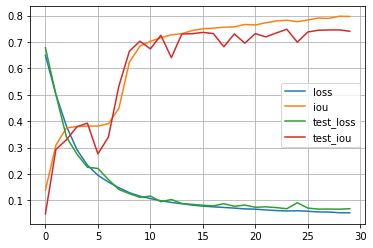

In [48]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()